In [1]:
import pandas as pd
import numpy as np

## Preprocessamento dos dados

In [2]:
# Load the dataset after the exploratory data analysis
# challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v7.csv")
challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v9_median.csv")
submission_set = pd.read_csv("./data/submission_set.csv")
# submission_set_updated = pd.read_csv("./data/submission_set_updated_v7.csv")
submission_set_updated = pd.read_csv("./data/submission_set_updated_v9_median.csv")

# If necessary change this part to test the model before the training process
df = challenge_set_updated.iloc[:,:]
# df = challenge_set_updated.sample(frac=0.001)

# Separating features and target variable
X = df.drop('tow', axis=1)
y = df['tow']

df.head()

,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,track_variation_ARR_100,track_variation_DEP_100,track_variation_ENR,...,Altitude_adep,Latitude_ades,Longitude_ades,Altitude_ades,altitude_difference,bearing,elevation_gradient,adep_geo_cluster,ades_geo_cluster,tow
0,EGLL,EICK,A320,M,a73f82288988b79be490c6322f4c32ed,18.0,321,124.339907,39.704139,2.102124,...,25,51.843,-8.492,154,129,277.346455,0.232363,13,0,54748.000000
1,LEBL,KMIA,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,13.0,4193,179.318890,8.910306,76.029652,...,4,25.793,-80.291,3,-1,285.530704,-0.000133,19,12,185441.000000
2,ESSA,KORD,A333,H,8be5c854fd664bcb97fb543339f74770,15.0,3770,179.638848,32.391881,85.115541,...,38,41.979,-87.904,204,166,305.643136,0.024214,8,15,230396.000000
3,LSZH,KPHL,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,11.0,3607,0.208347,36.998783,101.712676,...,432,39.872,-75.241,12,-420,296.005451,-0.065017,2,1,157615.000000
4,EIDW,EGLL,A21N,M,a73f82288988b79be490c6322f4c32ed,14.0,305,74.373402,174.878799,29.204750,...,74,51.477,-0.461,25,-49,116.445141,-0.109150,0,13,70318.447226


## Modelo (com pre-processamento auto)

In [3]:
cat_names = ['adep',
             'ades',
             'aircraft_type', 
             'wtc', 
             'airline',
             'offblock_hour',
             'offblock_minute', 
             'offblock_day_of_week',
             'offblock_month',
             'offblock_week_of_year', 
             'offblock_season', 
             'arrival_hour',
             'arrival_minute',
             'is_offblock_weekend',
             'is_offblock_rush_hour',
             'flight_duration_category',                       
             'adep_region', 
             'ades_region', 
             'same_country_flight',
             'same_region_flight',                        
             'flight_direction',
             'is_intercontinental',
             'Manufacturer',
             'Model_FAA',
             'Physical_Class_Engine',
             'FAA_Weight',
             'adep_geo_cluster',
             'ades_geo_cluster']

In [4]:
null_value_stats = df.isnull().sum(axis=0)
print(null_value_stats)

adep                  0
ades                  0
aircraft_type         0
wtc                   0
airline               0
                     ..
bearing               0
elevation_gradient    0
adep_geo_cluster      0
ades_geo_cluster      0
tow                   0
Length: 78, dtype: int64


In [5]:
X = df.drop('tow', axis=1)
y = df.tow

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create correlation matrix
corr_matrix = X.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

# corr_matrix['offblock_week_of_year'].sort_values(ascending=False).head()
# corr_matrix['offblock_to_arrival_duration'].sort_values(ascending=False).head()
# corr_matrix['normalized_taxi_ratio'].sort_values(ascending=False).head()
# corr_matrix['MALW_kg'].sort_values(ascending=False).head()

# Plotting the correlation matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix[to_drop, to_drop], annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Challenge Set')
# plt.show()

# # Drop features 
X.drop(['offblock_to_arrival_duration', 'normalized_taxi_ratio', 'MALW_kg'], axis=1, inplace=True)

['offblock_week_of_year', 'offblock_to_arrival_duration', 'normalized_taxi_ratio', 'MALW_kg']


In [7]:
print(X.dtypes)

adep                    object
ades                    object
aircraft_type           object
wtc                     object
airline                 object
                        ...   
altitude_difference      int64
bearing                float64
elevation_gradient     float64
adep_geo_cluster         int64
ades_geo_cluster         int64
Length: 74, dtype: object


In [8]:
from catboost import CatBoostRegressor, Pool, metrics
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'learning_rate': 0.05, 
    'reg_lambda': 69.07051080443502, 
    'subsample': 0.9831691718361609, 
    'random_strength': 16.348436502754343, 
    'depth': 11, 
    'colsample_bylevel': 0.9434202103659302, 
    'min_data_in_leaf': 2, 
    'leaf_estimation_iterations': 7
    # 'reg_lambda': 15.865685490104017, 
    # 'random_strength': 33.58229075926253, 
    # 'depth': 11, 
    # 'min_data_in_leaf': 3, 
    # 'leaf_estimation_iterations': 15
}
train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool = Pool(X_val, y_val, cat_features=cat_names)

model = CatBoostRegressor(
    iterations=5000,
    objective=metrics.RMSE(),
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    task_type='GPU',
    use_best_model=True,
    od_type='Iter',
    od_wait=20,
    **params,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 5
bestTest = 2946.519493
bestIteration = 4766
Shrink model to first 4767 iterations.
Feature #19 eliminated
Feature #13 eliminated
Feature #7 eliminated
Feature #43 eliminated
Feature #59 eliminated
Feature #31 eliminated
Feature #25 eliminated
Feature #22 eliminated
Feature #20 eliminated
Step #2 out of 5
bestTest = 2937.187332
bestIteration = 4999
Feature #42 eliminated
Feature #9 eliminated
Feature #16 eliminated
Feature #10 eliminated
Feature #5 eliminated
Feature #8 eliminated
Feature #14 eliminated
Step #3 out of 5
bestTest = 2916.402706
bestIteration = 4997
Shrink model to first 4998 iterations.
Feature #36 eliminated
Feature #15 eliminated
Feature #30 eliminated
Feature #45 eliminated
Feature #26 eliminated
Feature #28 eliminated
Feature #44 eliminated
Step #4 out of 5
bestTest = 2905.822482
bestIteration = 3835
Shrink model to first 3836 iterations.
Feature #21 eliminated
Feature #18 eliminated
Feature #69 eliminated
Feature #12 eliminated
Feature #70 eliminated

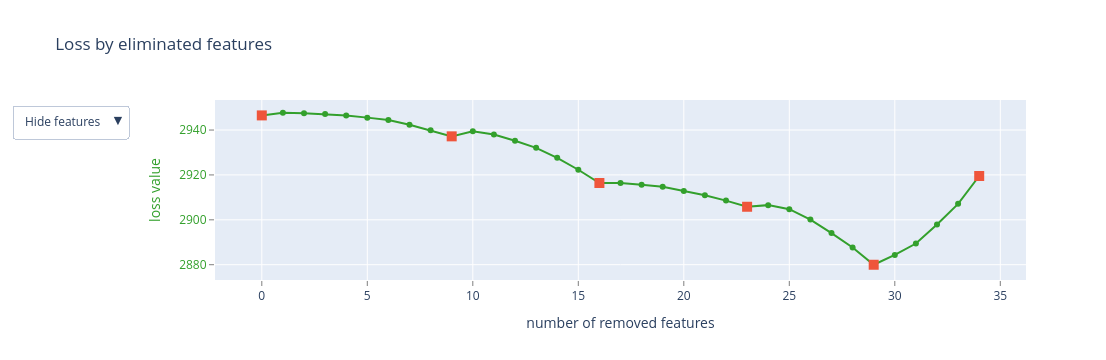

In [37]:
result = model.select_features(
    train_pool, eval_set=val_pool,
    features_for_select=X_train.columns.tolist(),
    num_features_to_select=40,
    steps=5,
    plot=True,
)

In [8]:
print(result['eliminated_features_names'])

NameError: name 'result' is not defined

In [9]:
X.drop(['wind_distance_ARR_100', 'average_airspeed_ARR_100', 'track_variation_ARR_100', 
        'is_offblock_weekend', 'Num_Engines', 'flown_distance_ARR_100', 'average_humidity_ARR_100',
        'average_temperature_ARR_100', 'wind_distance_DEP_100', 'arrival_minute', 'track_variation_ENR',
        'groundspeed_ARR_100', 'average_vertical_rate_ARR_100', 'taxiout_time', 'track_variation_DEP_100',
        'average_airspeed_DEP_100', 'offblock_minute', 'average_airspeed_ENR', 'specific_energy_ENR',
        'taxi_ratio', 'average_humidity_DEP_100', 'specific_energy_ARR_100', 'is_offblock_rush_hour',
        'wind_distance_ENR', 'groundspeed_ENR', 'altitude_difference', 'average_vertical_rate_ENR',
        'bearing', 'Altitude_ades'], axis=1, inplace=True)

In [10]:
print(result['eliminated_features_names'])
X.drop(result['eliminated_features_names'], axis=1, inplace=True)

NameError: name 'result' is not defined

In [10]:
eliminated = ['wind_distance_ARR_100', 'average_airspeed_ARR_100', 'track_variation_ARR_100', 
        'is_offblock_weekend', 'Num_Engines', 'flown_distance_ARR_100', 'average_humidity_ARR_100',
        'average_temperature_ARR_100', 'wind_distance_DEP_100', 'arrival_minute', 'track_variation_ENR',
        'groundspeed_ARR_100', 'average_vertical_rate_ARR_100', 'taxiout_time', 'track_variation_DEP_100',
        'average_airspeed_DEP_100', 'offblock_minute', 'average_airspeed_ENR', 'specific_energy_ENR',
        'taxi_ratio', 'average_humidity_DEP_100', 'specific_energy_ARR_100', 'is_offblock_rush_hour',
        'wind_distance_ENR', 'groundspeed_ENR', 'altitude_difference', 'average_vertical_rate_ENR',
        'bearing', 'Altitude_ades']
selected_cat_names = [x for x in cat_names if x not in eliminated]

# print(selected_cat_names)
# print(result['eliminated_features_names'])

In [11]:
from catboost import CatBoostRegressor, Pool, metrics
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'learning_rate': 0.01, 
    'reg_lambda': 69.07051080443502, 
    'subsample': 0.9831691718361609, 
    'random_strength': 16.348436502754343, 
    'depth': 11, 
    'colsample_bylevel': 0.9434202103659302, 
    'min_data_in_leaf': 2, 
    'leaf_estimation_iterations': 7
    # 'reg_lambda': 15.865685490104017, 
    # 'random_strength': 33.58229075926253, 
    # 'depth': 11, 
    # 'min_data_in_leaf': 3, 
    # 'leaf_estimation_iterations': 15
}
train_pool = Pool(X_train, y_train, cat_features=selected_cat_names)
val_pool = Pool(X_val, y_val, cat_features=selected_cat_names)

model = CatBoostRegressor(
    iterations=50000,
    objective=metrics.RMSE(),
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    task_type='CPU',
    use_best_model=True,
    od_type='Iter',
    od_wait=50,
    **params,
)

In [12]:
model.fit(
    train_pool, eval_set=val_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
best_iteration = model.get_best_iteration()
model = CatBoostRegressor(
    iterations=36104,#best_iteration
    objective=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    task_type='CPU',
    **params,
)
model.fit(
    X, y, cat_features=selected_cat_names, plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

MTOW_kg: 24.03111035241858
FAA_Weight: 22.76016872684214
MALW_kg: 5.570555389017825
wtc: 5.111954710843343
airline: 4.743464084514861
Manufacturer: 4.355679639346204
Approach_Speed_knot: 3.9841667223017287
aircraft_type: 2.6993183496225153
Model_FAA: 2.4998271448984832
flight_duration_category: 1.843810841452681
adep_region: 1.5633793320850875
ades_region: 1.5600975820680538
ades_geo_cluster: 1.0251854052330738
same_region_flight: 0.9592194562945926
flown_distance: 0.9084022435406115
offblock_minute: 0.8280612789843642
offblock_to_arrival_duration: 0.7974440126251763
offblock_hour: 0.7835942981145246
Longitude_adep: 0.7582431500030101
adep_geo_cluster: 0.698792299017662
flight_direction: 0.5921521443075404
Altitude_adep: 0.5867450830780605
offblock_day_of_week: 0.5781904228187235
average_vertical_rate_DEP_100: 0.574083931140468
offblock_season: 0.4536097231349992
arrival_hour: 0.4202830816355176
Latitude_adep: 0.3966773351448594
cumulative_avg_speed: 0.37096076835870784
groundspeed_DEP

In [39]:
trajectory_features = [
    'track_variation_ARR_100',
    'track_variation_DEP_100',
    'track_variation_ENR',
    'average_vertical_rate_ARR_100',
    'average_vertical_rate_DEP_100',
    'average_vertical_rate_ENR',
    'average_airspeed_ARR_100',
    'average_airspeed_DEP_100'
    'average_airspeed_ENR',
    'groundspeed_ARR_100',
    'groundspeed_DEP_100',
    'groundspeed_ENR',
    'wind_distance_ARR_100',
    'wind_distance_DEP_100',
    'wind_distance_ENR',
    'average_temperature_ARR_100',
    'average_temperature_DEP_100',
    'average_temperature_ENR',
    'average_humidity_ARR_100',
    'average_humidity_DEP_100',
    'average_humidity_ENR',
    'specific_energy_ARR_100',
    'specific_energy_DEP_100',
    'specific_energy_ENR',
    'flown_distance_ARR_100',
    'flown_distance_DEP_100',
    'flown_distance_ENR',
    'specific_energy',
]

for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if name in trajectory_features:
        print('{}: {}'.format(name, score))

average_vertical_rate_DEP_100: 0.574083931140468
groundspeed_DEP_100: 0.3645546969632437
specific_energy: 0.31586545397813015
flown_distance_ENR: 0.31139116536766803
average_temperature_DEP_100: 0.2892935766746952
average_humidity_ENR: 0.24392240997859588
specific_energy_DEP_100: 0.2031901502170664
average_temperature_ENR: 0.20290516138498071
average_vertical_rate_ENR: 0.17808981677107025
track_variation_DEP_100: 0.15797206244771841
specific_energy_ARR_100: 0.15641668027448732
average_vertical_rate_ARR_100: 0.14773389441392465
track_variation_ENR: 0.13357880959301793
wind_distance_ENR: 0.122644101983693
flown_distance_DEP_100: 0.12033414605487082
groundspeed_ARR_100: 0.11000039866371526
specific_energy_ENR: 0.0944754781428843
average_humidity_DEP_100: 0.08993996019917065
wind_distance_DEP_100: 0.08287799561655092
groundspeed_ENR: 0.08084170903202333
average_humidity_ARR_100: 0.07404607017532402
track_variation_ARR_100: 0.07310592995559369
average_temperature_ARR_100: 0.0725674975704653

## Training on GPU

In [ ]:
params = {
    'objective': 'RMSE',
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.RMSE(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False,
    'task_type': 'GPU',
}
train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool = Pool(X_val, y_val, cat_features=cat_names)

In [ ]:
%%time
from sklearn.metrics import mean_squared_error

model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=val_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostRegressor(**best_model_params)
best_model.fit(train_pool, eval_set=val_pool)

print('Simple model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, model.predict(X_val))
))
print('')

print('Best model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, best_model.predict(X_val))
))

## Features Importances

In [ ]:
model = CatBoostRegressor(**params).fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

## Hyperparameter Tunning

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial):
    # Taken from: https://deepnote.com/app/svpino/Tuning-Hyperparameters-with-Optuna-ea1a123d-8d2f-4e20-8f22-95f07470d557
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100),
        # 'subsample': trial.suggest_float('subsample', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 10, 50),
        'depth': trial.suggest_int('depth', 1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
    }
    
    model = CatBoostRegressor(
        iterations=1000,
        eval_metric=metrics.RMSE(),
        random_seed=42,
        verbose=False,
        objective=metrics.RMSE(),
        task_type='GPU', # training on GPU
        use_best_model=True,
        od_type='Iter',
        od_wait=20,
        **params,
    )

    cv_data = cv(
        train_pool,
        model.get_params(),
        logging_level='Silent',
    )
    best_rmse = np.min(cv_data['test-RMSE-mean'])

    return best_rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Display the best hyperparameters found
print(f"Best trial: {study.best_trial.params}")

# Train the final model with the best parameters
best_params = study.best_trial.params
best_model = CatBoostRegressor(
    iterations=5000,
    eval_metric=metrics.RMSE(),
    random_seed=42,
    logging_level='Silent',
    objective=metrics.RMSE(),
    task_type='GPU', # training on GPU
    use_best_model=True,
    od_type='Iter',
    od_wait=20,
    **best_params,
)

# Train the model with early stopping
best_model.fit(train_pool, eval_set=val_pool)

In [ ]:
model = CatBoostRegressor(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=3000,
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    objective=metrics.RMSE(),
    task_type='GPU',
    use_best_model=True,
)
cv_data = cv(Pool(X, y, cat_features=cat_names), model.get_params(), plot=True)

In [ ]:
print('RMSE score: {}'.format(np.min(cv_data['test-RMSE-mean'])))

In [ ]:
model.fit(train_pool, eval_set=val_pool)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
preds_val = model.predict(X_val)
diff_val = preds_val - y_val
plt.hist(diff_val, bins=200)
diff_val.mean(), diff_val.std()

In [ ]:
print('Model validation RMSE: {:.4}'.format(
    root_mean_squared_error(y_val * std + mean, preds_val * std + mean)
))

## Submissão

In [14]:
df_test = pd.read_csv("./data/submission_set_updated_v9_median.csv")
df_test.head()

,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,track_variation_ARR_100,track_variation_DEP_100,track_variation_ENR,...,Altitude_adep,Latitude_ades,Longitude_ades,Altitude_ades,altitude_difference,bearing,elevation_gradient,adep_geo_cluster,ades_geo_cluster,tow
0,LTFJ,LFLL,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,15.0,1122,74.373402,110.069323,50.723775,...,312,45.726,5.091,251,-61,293.477205,-0.030154,11,17,NaN
1,EBBR,KJFK,A333,H,bdeeef3a675587d530de70a25d7118d2,15.0,3205,98.664855,64.755647,93.023665,...,57,40.640,-73.779,4,-53,291.395141,-0.009004,6,1,NaN
2,KMIA,EGLL,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,10.0,3965,26.478102,73.771503,5.682069,...,3,51.477,-0.461,25,22,43.036806,0.003095,12,13,NaN
3,EGCN,LEAL,B38M,M,3922524069809ac4326134429751e26f,10.0,986,102.257838,176.128681,48.209089,...,55,38.282,-0.558,44,-11,178.644825,-0.006508,13,19,NaN
4,EIDW,LFLL,A320,M,a73f82288988b79be490c6322f4c32ed,15.0,686,5.653190,169.820834,50.924346,...,74,45.726,5.091,251,177,131.790949,0.149765,0,17,NaN


In [15]:
X_test = df_test.drop('tow', axis=1)

In [16]:
X_test.drop(eliminated, axis=1, inplace=True)
X_test.drop(['offblock_to_arrival_duration', 'normalized_taxi_ratio', 'MALW_kg'], axis=1, inplace=True)

In [17]:
y_pred = model.predict(X_test)
y_test = y_pred

In [18]:
y_test

array([ 68266.78600426, 213770.67537386, 224245.33000388, ...,
        74370.96606346,  61620.61662506,  61808.19147765])

In [19]:
dft0 = pd.read_csv('./data/submission_set.csv')
dft0['tow'] = y_test
dft0[['flight_id', 'tow']].to_csv('catboost.csv', index=False)

In [20]:
!head catboost.csv

flight_id,tow
248753821,68266.78600425777
248753822,213770.67537386174
248754498,224245.33000388148
248757623,65076.344158274136
248763603,63679.38214562848
248755068,57399.74407700941
248754229,53606.520341352574
248754894,57357.813335871804
248754751,55835.93413772961


In [21]:
submission_dataset = df_test
submission_dataset['tow'] = y_pred
# submission_dataset.head()
pd.set_option('display.max_rows', None)
# print(submission_dataset.T)
pd.reset_option('display.max_rows')
print((submission_dataset['tow'] > submission_dataset['MTOW_kg']).sum())
mask = (submission_dataset['tow'] > submission_dataset['MTOW_kg'])
submission_dataset.loc[mask, 'tow'] = submission_dataset.loc[mask, 'MTOW_kg']
print((submission_dataset['tow'] > submission_dataset['MTOW_kg']).sum())

61
0


In [22]:
dft0 = pd.read_csv('./data/submission_set.csv')
dft0['tow'] = submission_dataset['tow']
dft0[['flight_id', 'tow']].to_csv('catboost_sat.csv', index=False)

In [23]:
!mc cp ./catboost_sat.csv dc24/submissions/team_tiny_rainbow_v45_7ec66710-1eb8-478e-8976-584c090b6373.csv

...st_sat.csv: 2.85 MiB / 2.85 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 487.49 KiB/s 5s